In [2]:
#reference: https://www.kaggle.com/benjibb/lstm-stock-prediction-20170507?scriptVersionId=1139231
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
from keras.layers import Input
from keras.models import Model
import keras
import h5py
import requests
import os

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
Using TensorFlow backend.


In [3]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['adj close'] = min_max_scaler.fit_transform(df['adj close'].values.reshape(-1,1))
    return df

# function for build the training data and test data
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
#     print(result.shape)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
#     print(x_train.shape)
#     print(y_train.shape)
    
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]
#     print(x_test.shape)
#     print(y_test.shape)

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

In [5]:
df = pd.read_csv("data/prices-split-adjusted.csv", index_col = 0)
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df.head()

,symbol,open,low,high,volume,adj close
date,,,,,,
2016-01-05,WLTW,123.430000,122.309998,126.250000,2163600.0,125.839996
2016-01-06,WLTW,125.239998,119.940002,125.540001,2386400.0,119.980003
2016-01-07,WLTW,116.379997,114.930000,119.739998,2489500.0,114.949997
2016-01-08,WLTW,115.480003,113.500000,117.440002,2006300.0,116.620003
2016-01-11,WLTW,117.010002,114.089996,117.330002,1408600.0,114.970001


In [6]:
df = normalize_data(df)
df.head()


,symbol,open,low,high,volume,adj close
date,,,,,,
2016-01-05,WLTW,0.076934,0.078020,0.077818,0.002517,0.078812
2016-01-06,WLTW,0.078078,0.076490,0.077374,0.002776,0.075095
2016-01-07,WLTW,0.072480,0.073254,0.073747,0.002896,0.071904
2016-01-08,WLTW,0.071911,0.072331,0.072309,0.002334,0.072964
2016-01-11,WLTW,0.072878,0.072712,0.072240,0.001639,0.071917


In [7]:
symbols = list(set(df.symbol))
print symbols

['AGN', 'EOG', 'CPB', 'EVHC', 'IDXX', 'SIG', 'JWN', 'JBHT', 'TAP', 'VRTX', 'BWA', 'UAL', 'UAA', 'WM', 'SPG', 'ENDP', 'GT', 'GIS', 'PYPL', 'MJN', 'WRK', 'ROP', 'GE', 'GD', 'VAR', 'AMZN', 'NTAP', 'MAS', 'MAR', 'MAT', 'SNA', 'FOXA', 'SNI', 'MAA', 'MAC', 'JNJ', 'XYL', 'TSN', 'SYMC', 'BEN', 'CMI', 'DISCA', 'CMG', 'ALB', 'CME', 'CMA', 'CMS', 'PCG', 'VLO', 'HUM', 'PCLN', 'TGNA', 'FSLR', 'HCP', 'FTR', 'FTV', 'K', 'FFIV', 'BLL', 'HCA', 'BLK', 'FTI', 'HCN', 'NFX', 'MA', 'CBG', 'PRGO', 'MO', 'NOC', 'MU', 'CBS', 'NDAQ', 'SE', 'TJX', 'NOV', 'AMGN', 'FB', 'COST', 'FE', 'CTL', 'ADBE', 'FL', 'DOW', 'MSFT', 'GLW', 'SCHW', 'BSX', 'GGP', 'FCX', 'UPS', 'WHR', 'BBBY', 'MDT', 'F', 'DFS', 'JEC', 'ILMN', 'V', 'FMC', 'MPC', 'TSCO', 'ALL', 'ALK', 'LMT', 'MMM', 'SO', 'JNPR', 'MMC', 'WEC', 'SWKS', 'DPS', 'IBM', 'FIS', 'BAX', 'CAT', 'CAH', 'GM', 'BAC', 'GS', 'CAG', 'LB', 'LH', 'PGR', 'HIG', 'CELG', 'WLTW', 'A', 'ABC', 'ZION', 'STI', 'ANTM', 'ABT', 'XOM', 'STX', 'STZ', 'BHI', 'CERN', 'CFG', 'PNR', 'PNW', 'IVZ', 'PN

In [8]:
science_list = ['GOOG','AAPL','YHOO','AMZN']
encoding_dim = 10 
# for symbol in science_list:
#     thisdf = df[df.symbol == symbol]
#     input_img = Input(shape=(22,))
#     encoded = Dense(encoding_dim, activation='relu')(input_img)
#     decoded = Dense(784, activation='sigmoid')(encoded)
#     autoencoder = Model(input_img, decoded)
#     encoder = Model(input_img, encoded)
stock_interest = 'AAPL'
df3 = df[df.symbol == stock_interest]
df3.drop(['symbol'],1,inplace=True)
df3.head()

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,open,low,high,volume,adj close
date,,,,,
2010-01-04,0.018215,0.018625,0.018030,0.143586,0.018384
2010-01-05,0.018320,0.018705,0.018128,0.175045,0.018417
2010-01-06,0.018301,0.018475,0.018096,0.160578,0.018108
2010-01-07,0.018063,0.018318,0.017807,0.138758,0.018073
2010-01-08,0.017932,0.018319,0.017807,0.130173,0.018200


In [9]:
window = 22
X_train, y_train, X_test, y_test = load_data(df3, window)
print X_train.shape

(1565, 22, 5)


In [10]:
print X_train.shape
X_train = X_train.reshape(1565,22*5)


(1565, 22, 5)


In [11]:
print X_test.shape
X_test = X_test.reshape(174,22*5)

(174, 22, 5)


In [12]:
#Test the performance of autoencoder on the time series
# build the model
input_img = Input(shape=(22*5,))
encoding_dim = 10 
encoded = Dense(encoding_dim, activation='relu')(input_img)
decoded = Dense(22*5, activation='linear')(encoded)
autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [13]:
print X_train
earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
autoencoder.fit(X_train, X_train,
                epochs=150,
                batch_size=256,
                callbacks=[earlyStopping],
                shuffle=True,
                validation_data=(X_test, X_test))

[[ 0.01821479  0.0186252   0.01803045 ...,  0.01675296  0.17894862
   0.01704456]
 [ 0.01832039  0.01870546  0.01812783 ...,  0.01658948  0.22033904
   0.01639395]
 [ 0.01830053  0.01847482  0.01809567 ...,  0.01637776  0.24728475
   0.01670294]
 ..., 
 [ 0.0661368   0.06696417  0.06546725 ...,  0.06640527  0.03767248
   0.06680452]
 [ 0.06587776  0.06693188  0.0661864  ...,  0.06646155  0.03560895
   0.06694407]
 [ 0.06544814  0.06697709  0.06596128 ...,  0.06573615  0.03670417
   0.06620828]]
Train on 1565 samples, validate on 174 samples
Epoch 1/150
1565/1565 [==============================] - 0s 179us/step - loss: 0.0064 - val_loss: 0.0041
Epoch 2/150
1565/1565 [==============================] - 0s 23us/step - loss: 0.0059 - val_loss: 0.0037
Epoch 3/150
1565/1565 [==============================] - 0s 27us/step - loss: 0.0055 - val_loss: 0.0033
Epoch 4/150
1565/1565 [==============================] - 0s 28us/step - loss: 0.0051 - val_loss: 0.0030
Epoch 5/150
1565/1565 [=============

In [14]:
# thisx = X_test
print X_test.shape
thisx = np.array([X_test[1,:]])
print thisx.shape
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)


(174, 110)
(1, 110)


In [15]:

print thisx
print decoded_imgs[0]


[[ 0.06558713  0.06677043  0.06531092  0.03039981  0.06601799  0.06592199
   0.06688022  0.0652734   0.02258076  0.06571353  0.06522069  0.06676397
   0.06627395  0.0362826   0.06729293  0.06759626  0.06916639  0.0679186
   0.05304653  0.06848542  0.06827228  0.06934721  0.06759343  0.03011528
   0.06812386  0.06767839  0.06890806  0.06765596  0.03009853  0.06875817
   0.06871454  0.07024489  0.06902546  0.04345546  0.06947493  0.06813961
   0.06969595  0.06811246  0.03091829  0.06864399  0.0685945   0.06955387
   0.0682688   0.03071518  0.06937344  0.0684176   0.0688564   0.0679186
   0.03699429  0.06783843  0.06776053  0.06888869  0.06751213  0.02743196
   0.06791455  0.06779843  0.06931493  0.06803742  0.03420895  0.06814289
   0.0680322   0.06920514  0.06796863  0.0316786   0.0690436   0.06895463
   0.07058718  0.06911926  0.03868732  0.07005848  0.0694727   0.07092946
   0.06915053  0.0296331   0.07009654  0.06978229  0.06989616  0.06909425
   0.05460287  0.06866936  0.06774789  0

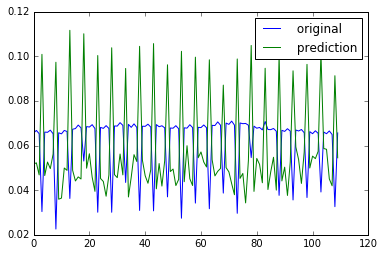

In [16]:
plt.plot(thisx[0],label = ' original')
plt.plot(decoded_imgs[0],label = ' prediction')
plt.legend()
plt.show()

In [17]:
#TODO
science_list = ['GOOG','AAPL','YHOO','AMZN']
encoder_list = []
decoder_list = []
window = 22
for symbol in science_list:
    # prepare the data
    df3 = df[df.symbol == symbol]
    df3.drop(['symbol'],1,inplace=True)
    df3.head()
    X_train, y_train, X_test, y_test = load_data(df3, window)
    X_train = X_train.reshape(X_train.shape[0],22*5)
    X_test = X_test.reshape(X_test.shape[0],22*5)
    
    
    
    # train an autoencoder 
    input_img = Input(shape=(22*5,))
    encoding_dim = 10 
    encoded = Dense(encoding_dim, activation='relu')(input_img)
    decoded = Dense(22*5, activation='linear')(encoded)
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    encoded_input = Input(shape=(encoding_dim,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
    earlyStopping=keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0, mode='auto')
    autoencoder.fit(X_train, X_train,
                epochs=150,
                batch_size=256,
                callbacks=[earlyStopping],
                shuffle=True,
                validation_data=(X_test, X_test))
    
#     autoencoder_list.append(None) # append the trained autoencoder
    encoder_list.append(encoder)
    decoder_list.append(decoder)

    
# generate the predicted values for all stocks and put them in one matrix
# train a LSTM using those values
# test the results


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Train on 1565 samples, validate on 174 samples
Epoch 1/150
1565/1565 [==============================] - 0s 210us/step - loss: 0.0613 - val_loss: 0.1645
Epoch 2/150
1565/1565 [==============================] - 0s 22us/step - loss: 0.0576 - val_loss: 0.1570
Epoch 3/150
1565/1565 [==============================] - 0s 27us/step - loss: 0.0546 - val_loss: 0.1498
Epoch 4/150
1565/1565 [==============================] - 0s 19us/step - loss: 0.0515 - val_loss: 0.1419
Epoch 5/150
1565/1565 [==============================] - 0s 23us/step - loss: 0.0482 - val_loss: 0.1327
Epoch 6/150
1565/1565 [==============================] - 0s 22us/step - loss: 0.0444 - val_loss: 0.1223
Epoch 7/150
1565/1565 [==============================] - 0s 19us/step - loss: 0.0402 - val_loss: 0.1102
Epoch 8/150
1565/1565 [==============================] - 0s 14us/step - loss: 0.0355 - val_loss: 0.0968
Epoch 9/150
1565/1565 [==============================] - 0s 23us/step - loss: 0.0306 - val_loss: 0.0825
Epoch 10/150
156

Epoch 146/150
1565/1565 [==============================] - 0s 17us/step - loss: 6.6937e-05 - val_loss: 1.0052e-04
Epoch 147/150
1565/1565 [==============================] - 0s 16us/step - loss: 6.6813e-05 - val_loss: 9.9999e-05
Epoch 148/150
1565/1565 [==============================] - 0s 16us/step - loss: 6.6690e-05 - val_loss: 9.8662e-05
Epoch 149/150
1565/1565 [==============================] - 0s 21us/step - loss: 6.6544e-05 - val_loss: 9.7153e-05
Epoch 150/150
1565/1565 [==============================] - 0s 18us/step - loss: 6.6445e-05 - val_loss: 9.6248e-05
Train on 1565 samples, validate on 174 samples
Epoch 1/150
1565/1565 [==============================] - 0s 173us/step - loss: 0.0059 - val_loss: 0.0039
Epoch 2/150
1565/1565 [==============================] - 0s 18us/step - loss: 0.0055 - val_loss: 0.0035
Epoch 3/150
1565/1565 [==============================] - 0s 20us/step - loss: 0.0051 - val_loss: 0.0032
Epoch 4/150
1565/1565 [==============================] - 0s 18us/step 

1565/1565 [==============================] - 0s 17us/step - loss: 9.5141e-05 - val_loss: 9.8056e-05
Epoch 94/150
1565/1565 [==============================] - 0s 16us/step - loss: 9.5102e-05 - val_loss: 9.8481e-05
Epoch 95/150
1565/1565 [==============================] - 0s 13us/step - loss: 9.5070e-05 - val_loss: 9.8711e-05
Epoch 96/150
1565/1565 [==============================] - 0s 13us/step - loss: 9.5047e-05 - val_loss: 9.8499e-05
Epoch 97/150
1565/1565 [==============================] - 0s 18us/step - loss: 9.5019e-05 - val_loss: 9.9004e-05
Epoch 98/150
1565/1565 [==============================] - 0s 23us/step - loss: 9.4992e-05 - val_loss: 9.8932e-05
Epoch 99/150
1565/1565 [==============================] - 0s 23us/step - loss: 9.4960e-05 - val_loss: 9.8618e-05
Epoch 100/150
1565/1565 [==============================] - 0s 20us/step - loss: 9.4937e-05 - val_loss: 9.8384e-05
Epoch 101/150
1565/1565 [==============================] - 0s 21us/step - loss: 9.4913e-05 - val_loss: 9.880

1565/1565 [==============================] - 0s 17us/step - loss: 2.0087e-04 - val_loss: 0.0013
Epoch 58/150
1565/1565 [==============================] - 0s 13us/step - loss: 1.9491e-04 - val_loss: 0.0013
Epoch 59/150
1565/1565 [==============================] - 0s 15us/step - loss: 1.8917e-04 - val_loss: 0.0013
Epoch 60/150
1565/1565 [==============================] - 0s 16us/step - loss: 1.8363e-04 - val_loss: 0.0013
Epoch 61/150
1565/1565 [==============================] - 0s 17us/step - loss: 1.7872e-04 - val_loss: 0.0012
Epoch 62/150
1565/1565 [==============================] - 0s 23us/step - loss: 1.7379e-04 - val_loss: 0.0012
Epoch 63/150
1565/1565 [==============================] - 0s 22us/step - loss: 1.6912e-04 - val_loss: 0.0011
Epoch 64/150
1565/1565 [==============================] - 0s 22us/step - loss: 1.6486e-04 - val_loss: 0.0011
Epoch 65/150
1565/1565 [==============================] - 0s 23us/step - loss: 1.6047e-04 - val_loss: 0.0011
Epoch 66/150
1565/1565 [========

In [18]:
# train the main model
# for stock in list
# get the data and transform the data
#  bulid the train data
# put into keras

print encoded_imgs[4]

[ 0.          0.          0.          0.01852829  0.06664444  0.          0.
  0.          0.03028574  0.        ]


In [22]:
def generate_data(df,symbol_list,encoder_list,deoder_list,window,feature_len):
    data = []
    testdata = []
    label = []
    testlabel = []
    num_symbol = len(symbol_list)
    first = 0
    for symbol in symbol_list:
        df3 = df[df.symbol == symbol]
        df3.drop(['symbol'],1,inplace=True)
        X_train, y_train, X_test, y_test = load_data(df3, window)
        
        X_train = X_train.reshape(X_train.shape[0],22*5)
        num_train = X_train.shape[0]
        X_test = X_test.reshape(X_test.shape[0],22*5)
        num_test = X_test.shape[0]

        
        thisdata = np.zeros([num_train,num_symbol * feature_len])
        thistest = np.zeros([num_test,num_symbol * feature_len])
        print num_test
        i = 0
        for encoder in encoder_list:
            
            encoded_imgs = encoder.predict(X_train)
            thisdata[:,i*feature_len:(i+1)*feature_len] = encoded_imgs
            encoded_imgs = encoder.predict(X_test)
            thistest[:,i*feature_len:(i+1)*feature_len] = encoded_imgs
            i += 1
        if first == 0:
            data = thisdata
            first =1
            testdata = thistest
            label = y_train
            testlabel = y_test
            print testdata.shape
        else:
            data = np.append(data,thisdata,axis=0)
            testdata = np.append(testdata,thistest,axis=0)
            label = np.append(label,y_train)
            testlabel = np.append(testlabel,y_test)
            print testdata.shape
    return data,testdata,label,testlabel


def generate_data_decoded(df,symbol_list,encoder_list,deoder_list,window,feature_len):
    data = []
    testdata = []
    label = []
    testlabel = []
    num_symbol = len(symbol_list)
    first = 0
    for symbol in symbol_list:
        df3 = df[df.symbol == symbol]
        df3.drop(['symbol'],1,inplace=True)
        X_train, y_train, X_test, y_test = load_data(df3, window)
        
        X_train = X_train.reshape(X_train.shape[0],22*5)
        num_train = X_train.shape[0]
        X_test = X_test.reshape(X_test.shape[0],22*5)
        num_test = X_test.shape[0]

        
        thisdata = np.zeros([num_train,window,num_symbol * feature_len])
        thistest = np.zeros([num_test,window,num_symbol * feature_len])
        print num_test
        i = 0
        for encoder in encoder_list:
            
            encoded_imgs = encoder.predict(X_train)
            decoded_imgs = decoder.predict(encoded_imgs)
            decoded_imgs = decoded_imgs.reshape(num_train,window,feature_len)
            print decoded_imgs.shape
            
            thisdata[:,:,i*feature_len:(i+1)*feature_len] = decoded_imgs
            encoded_imgs = encoder.predict(X_test)
            decoded_imgs = decoder.predict(encoded_imgs)
            decoded_imgs = decoded_imgs.reshape(num_test,window,feature_len)
            thistest[:,:,i*feature_len:(i+1)*feature_len] = decoded_imgs
            i += 1
        if first == 0:
            data = thisdata
            first =1
            testdata = thistest
            label = y_train
            testlabel = y_test
            print testdata.shape
        else:
            data = np.append(data,thisdata,axis=0)
            testdata = np.append(testdata,thistest,axis=0)
            label = np.append(label,y_train)
            testlabel = np.append(testlabel,y_test)
            print testdata.shape
    return data,testdata,label,testlabel
xx = generate_data(df,science_list,encoder_list,decoder_list,window,10)
xx2 = generate_data_decoded(df,science_list,encoder_list,decoder_list,window,5)    

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


174
(174, 40)
174
(348, 40)
174
(522, 40)
174
(696, 40)


/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


174
(1565, 22, 5)
(1565, 22, 5)
(1565, 22, 5)
(1565, 22, 5)
(174, 22, 20)
174
(1565, 22, 5)
(1565, 22, 5)
(1565, 22, 5)
(1565, 22, 5)
(348, 22, 20)
174
(1565, 22, 5)
(1565, 22, 5)
(1565, 22, 5)
(1565, 22, 5)
(522, 22, 20)
174
(1565, 22, 5)
(1565, 22, 5)
(1565, 22, 5)
(1565, 22, 5)
(696, 22, 20)


In [23]:
print np.array(xx).shape
print xx[0].shape
print xx[1].shape
print xx[2].shape
print xx[3].shape
# xx = xx.reshape(1565,10*4)

(4,)
(6260, 40)
(696, 40)
(6260,)
(696,)


In [27]:
def build_model1(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model
def build_model2(layers):
    d = 0.3
    model = Sequential()
    print layers
#     model.add(LSTM(256, input_dim=layers[0], return_sequences=True))
#     model.add(Dropout(d))        
#     model.add(LSTM(256, input_dim=layers[0], return_sequences=False))
#     model.add(Dropout(d))
    model.add(Dense(32,input_dim = 40, kernel_initializer="uniform",activation='relu')) 
    model.add(Dropout(d))
#     model.add(Dense(32, kernel_initializer="uniform",activation='relu')) 
#     model.add(Dropout(d))
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    # adam = keras.optimizers.Adam(decay=0.2)
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [28]:
model = build_model2([40,1])
model2 = build_model1([20,window,1])

[40, 1]
('Compilation Time : ', 0.07445597648620605)
('Compilation Time : ', 0.05455303192138672)


In [29]:
# X_train = xx[0].reshape(xx[0].shape[0],)
model.fit(xx[0],xx[2],batch_size=512,epochs=90,validation_split=0.1,verbose=1)
model2.fit(xx2[0],xx2[2],batch_size=512,epochs=90,validation_split=0.1,verbose=1)

Train on 5634 samples, validate on 626 samples
Epoch 1/90
5634/5634 [==============================] - 1s 148us/step - loss: 0.0193 - acc: 0.0000e+00 - val_loss: 0.0331 - val_acc: 0.0000e+00
Epoch 2/90
5634/5634 [==============================] - 0s 11us/step - loss: 0.0067 - acc: 0.0000e+00 - val_loss: 0.0041 - val_acc: 0.0000e+00
Epoch 3/90
5634/5634 [==============================] - 0s 10us/step - loss: 0.0016 - acc: 0.0000e+00 - val_loss: 8.4907e-04 - val_acc: 0.0000e+00
Epoch 4/90
5634/5634 [==============================] - 0s 13us/step - loss: 0.0018 - acc: 0.0000e+00 - val_loss: 3.2968e-04 - val_acc: 0.0000e+00
Epoch 5/90
5634/5634 [==============================] - 0s 9us/step - loss: 9.5623e-04 - acc: 0.0000e+00 - val_loss: 9.9769e-04 - val_acc: 0.0000e+00
Epoch 6/90
5634/5634 [==============================] - 0s 11us/step - loss: 9.9249e-04 - acc: 0.0000e+00 - val_loss: 9.9760e-04 - val_acc: 0.0000e+00
Epoch 7/90
5634/5634 [==============================] - 0s 12us/step - 

Epoch 18/90
5634/5634 [==============================] - 27s 5ms/step - loss: 1.3979e-04 - acc: 0.0000e+00 - val_loss: 2.4325e-04 - val_acc: 0.0000e+00
Epoch 19/90
5634/5634 [==============================] - 27s 5ms/step - loss: 1.4080e-04 - acc: 0.0000e+00 - val_loss: 2.4447e-04 - val_acc: 0.0000e+00
Epoch 20/90
5634/5634 [==============================] - 27s 5ms/step - loss: 1.3802e-04 - acc: 0.0000e+00 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 21/90
5634/5634 [==============================] - 29s 5ms/step - loss: 6.3124e-04 - acc: 0.0000e+00 - val_loss: 0.0017 - val_acc: 0.0000e+00
Epoch 22/90
5634/5634 [==============================] - 28s 5ms/step - loss: 3.6871e-04 - acc: 0.0000e+00 - val_loss: 9.4092e-04 - val_acc: 0.0000e+00
Epoch 23/90
5634/5634 [==============================] - 29s 5ms/step - loss: 2.2745e-04 - acc: 0.0000e+00 - val_loss: 3.0784e-04 - val_acc: 0.0000e+00
Epoch 24/90
5634/5634 [==============================] - 28s 5ms/step - loss: 1.5309e-04 - acc: 

In [30]:
p = model.predict(xx[1])
p2 = model2.predict(xx2[1])

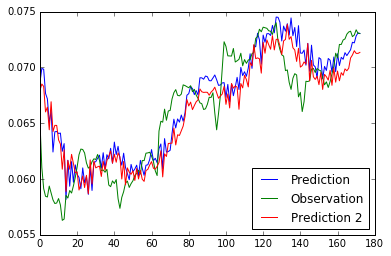

In [37]:
plt.plot(p[175:348],label = 'Prediction')
plt.plot(xx[3][175:348],label = 'Observation')
plt.plot(p2[175:348],label = 'Prediction 2')
plt.legend(loc='lower right')
plt.show()

In [34]:
print len(p2)

696


In [38]:
# TODO:
# 1. re-normalize
# 2. compare the loss
# 3. try with different symbols
# 4. play with build model two
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df = df[df.symbol == stock_interest]
df.drop(['symbol'],1,inplace=True)

def denormalize(df, normalized_value): 
    df = df['adj close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

IOError: File prices-split-adjusted.csv does not exist

In [39]:
# get the prediction from lstm
def build_model_baseline(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    # adam = keras.optimizers.Adam(decay=0.2)
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [40]:
stock_interest = 'GOOG'
df2 = df[df.symbol == stock_interest]
df2.drop(['symbol'],1,inplace=True)
df2 = normalize_data(df2)
window = 22
X_train, y_train, X_test, y_test = load_data(df2, window)
model = build_model([5,window,1])
model.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
plstm = model.predict(X_test)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

('Compilation Time : ', 0.05175614356994629)
Train on 1408 samples, validate on 157 samples
Epoch 1/90
1408/1408 [==============================] - 9s 7ms/step - loss: 0.1279 - acc: 7.1023e-04 - val_loss: 0.4933 - val_acc: 0.0000e+00
Epoch 2/90
1408/1408 [==============================] - 10s 7ms/step - loss: 0.0540 - acc: 7.1023e-04 - val_loss: 0.0495 - val_acc: 0.0000e+00
Epoch 3/90
1408/1408 [==============================] - 7s 5ms/step - loss: 0.0393 - acc: 7.1023e-04 - val_loss: 0.1482 - val_acc: 0.0000e+00
Epoch 4/90
1408/1408 [==============================] - 7s 5ms/step - loss: 0.0159 - acc: 7.1023e-04 - val_loss: 0.1960 - val_acc: 0.0000e+00
Epoch 5/90
1408/1408 [==============================] - 7s 5ms/step - loss: 0.0164 - acc: 7.1023e-04 - val_loss: 0.0918 - val_acc: 0.0000e+00
Epoch 6/90
1408/1408 [==============================] - 7s 5ms/step - loss: 0.0058 - acc: 7.1023e-04 - val_loss: 0.0348 - val_acc: 0.0000e+00
Epoch 7/90
1408/1408 [==============================] -

Epoch 58/90
1408/1408 [==============================] - 7s 5ms/step - loss: 9.5083e-04 - acc: 7.1023e-04 - val_loss: 0.0065 - val_acc: 0.0000e+00
Epoch 59/90
1408/1408 [==============================] - 7s 5ms/step - loss: 0.0011 - acc: 7.1023e-04 - val_loss: 0.0082 - val_acc: 0.0000e+00
Epoch 60/90
1408/1408 [==============================] - 7s 5ms/step - loss: 0.0010 - acc: 7.1023e-04 - val_loss: 0.0063 - val_acc: 0.0000e+00
Epoch 61/90
1408/1408 [==============================] - 7s 5ms/step - loss: 9.3828e-04 - acc: 7.1023e-04 - val_loss: 0.0071 - val_acc: 0.0000e+00
Epoch 62/90
1408/1408 [==============================] - 7s 5ms/step - loss: 9.8133e-04 - acc: 7.1023e-04 - val_loss: 0.0069 - val_acc: 0.0000e+00
Epoch 63/90
1408/1408 [==============================] - 7s 5ms/step - loss: 9.9364e-04 - acc: 7.1023e-04 - val_loss: 0.0066 - val_acc: 0.0000e+00
Epoch 64/90
1408/1408 [==============================] - 7s 5ms/step - loss: 9.9481e-04 - acc: 7.1023e-04 - val_loss: 0.0057 -

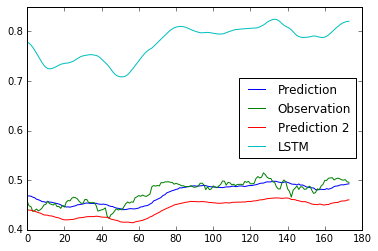

In [50]:
i = 0
plt.plot(p[i*175:(i+1)*175-1],label = 'Prediction')
plt.plot(xx[3][i*175:(i+1)*175-1],label = 'Observation')
plt.plot(p2[i*175:(i+1)*175-1],label = 'Prediction 2')
plt.plot(plstm,label='LSTM')
plt.legend(loc='best')
plt.show()

In [51]:
stock_interest = 'AAPL'
df2 = df[df.symbol == stock_interest]
df2.drop(['symbol'],1,inplace=True)
df2 = normalize_data(df2)
window = 22
X_train, y_train, X_test, y_test = load_data(df2, window)
model = build_model([5,window,1])
model.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)
plstm2 = model.predict(X_test)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

('Compilation Time : ', 0.1294848918914795)
Train on 1408 samples, validate on 157 samples
Epoch 1/90
1408/1408 [==============================] - 8s 5ms/step - loss: 0.2472 - acc: 7.1023e-04 - val_loss: 0.4481 - val_acc: 0.0000e+00
Epoch 2/90
1408/1408 [==============================] - 6s 4ms/step - loss: 0.1340 - acc: 7.1023e-04 - val_loss: 0.0498 - val_acc: 0.0000e+00
Epoch 3/90
1408/1408 [==============================] - 6s 4ms/step - loss: 0.0599 - acc: 0.0014 - val_loss: 0.0185 - val_acc: 0.0000e+00
Epoch 4/90
1408/1408 [==============================] - 6s 4ms/step - loss: 0.0482 - acc: 0.0014 - val_loss: 0.0970 - val_acc: 0.0000e+00
Epoch 5/90
1408/1408 [==============================] - 6s 4ms/step - loss: 0.0416 - acc: 7.1023e-04 - val_loss: 0.1157 - val_acc: 0.0000e+00
Epoch 6/90
1408/1408 [==============================] - 6s 4ms/step - loss: 0.0350 - acc: 7.1023e-04 - val_loss: 0.0398 - val_acc: 0.0000e+00
Epoch 7/90
1408/1408 [==============================] - 6s 4ms/st

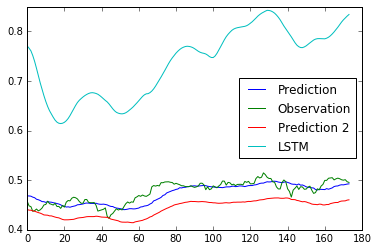

In [56]:
i = 0
plt.plot(p[i*175:(i+1)*175-1],label = 'Prediction')
plt.plot(xx[3][i*175:(i+1)*175-1],label = 'Observation')
plt.plot(p2[i*175:(i+1)*175-1],label = 'Prediction 2')
plt.plot(plstm2,label='LSTM')
plt.legend(loc='best')
plt.show()